# **Brain Tumor Detection**
### Brain tumor detection in MR image using superpixels, principal component analysis and template based K-means clustering algorithm

In [1]:
import numpy as np
import matplotlib.pyplot as plt # ploting your output
from sklearn.decomposition import PCA
from PIL import ImageFilter as f # median filter
import cv2 as cv
from skimage.segmentation import slic,mark_boundaries #superpixels
from math import floor
from skimage.util import img_as_float

## Preprocessing

In [2]:
def filterImg(img):
    fimg = img.filter(f.MedianFilter(size=3))
    return fimg

def superpixels(image):
    segments = slic(img_as_float(image),start_label = 1, n_segments = 100, sigma = 5)
    simg = mark_boundaries(img_as_float(cv.cvtColor(image, cv.COLOR_BGR2RGB)), segments)
    img = cv.cvtColor(image, cv.COLOR_RGB2GRAY)
#     plt.title("Reduced Image 1")
#     plt.imshow(simg)
#     plt.show()
    return img
    

def fPCA(img):
    img_df = img/255
    pca = PCA(n_components=50)
    pca.fit(img_df)
    trans_pca = pca.transform(img_df)
    img_reduced = pca.inverse_transform(trans_pca)
#     print(trans_pca.shape)
#     plt.title("Reduced Image 2")
#     plt.imshow(img_reduced,'gray')
#     plt.show()
    return img


def imageLoading(img_name):
    img = cv.imread(img_name)
#     fimg = filterImg(img)
    sup = superpixels(img)
    img = fPCA(sup)
    img = KMeans(img)
    X = img.shape[0]
    copy = np.copy(img)
    return [copy,X]



## Template based KMeans Clustering Algorithm

In [3]:
def TKMeans(inImg):
#     img = cv2.cvtColor(img, cv2.COLOR_2)
    nBins = 8
    winSize = 7
    nClass = 2
    img = inImg
    s = img.shape
    NbParam = nBins * nBins * nBins ;
    divis = 256 // nBins ;
    
    N=winSize;

    n=(N-1)//2;
    r=s[0]+2*n;
    c=s[1]+2*n;

    temp=np.zeros([r,c,3]);
    mat=np.zeros([r,c,3]);
    out=np.zeros([r,c,3]);
    coarseImg = np.zeros([r,c]);
    TabLabel = np.zeros([NbParam+1]);
  
    end = temp.shape[0]
    end1 = temp.shape[1]

    temp[(n):(end-n),(n):(end1-n),0]=img[:,:,0]
    temp[(n):(end-n),(n):(end1-n),1]=img[:,:,1]
    temp[(n):(end-n),(n):(end1-n),2]=img[:,:,2]

    temp_color = temp

    for x in range(n,s[0]+n-1):
        for y in range(n,s[1]+n-1):
            e=1
            for k in range(x-n-1,x+n-1):
                f=1
                for l in range(y-n-1,y+n-1):
                    mat[e,f,0]=temp[k,l,0]
                    mat[e,f,1]=temp[k,l,1]
                    mat[e,f,2]=temp[k,l,2]
                    f=f+1
                e=e+1

            sum_lab = 0;
            for i in range(0,winSize-1):
                for j in range(0 ,winSize-1):
                    lab = floor(mat[i,j,0]//divis)*(nBins*nBins);
                    lab = lab + floor(mat[i,j,1]//divis)*(nBins);
                    lab = lab + floor(mat[i,j,2]//divis);
                    lab = lab + 1;
                    TabLabel[lab] = TabLabel[lab] + 1;
                    sum_lab = sum_lab + lab;


            coarseImg[x,y] = floor(sum_lab // (winSize * winSize));

    end = coarseImg.shape[0]
    end1 = coarseImg.shape[1]

    trunCoarseImg = coarseImg[(n):(end-n),(n):(end1-n)];
    tempVar = trunCoarseImg[:,:]
    inImg_1D = tempVar[:,:]
#     return inImg_1D
    out = KMeans(inImg_1D)
#     fusedMapShow = np.uint8(out*(255/nClass))
#     outImg = cv.resize(fusedMapShow,(s[0],s[1]))
    return out.copy()

In [4]:
def KMeans(inImg_1D):
    img = inImg_1D
#     img = cv.imread("1.jpg")
    vectorized = img.reshape((-1))
    # print(vectorized.shape)
    vectorized = np.float32(vectorized)

    criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 100, 0)

    K=8
    attempts=10
    ret,label,center=cv.kmeans(vectorized,K,None,criteria,attempts,cv.KMEANS_RANDOM_CENTERS)
    label = label.flatten()

    center = np.uint8(center)
    res = center[label.flatten()]
    result_image = res.reshape((img.shape))

#     plt.imshow(result_image,"gray")
#     plt.title('Segmented Image when K = 8')
#     plt.show()
    return result_image.copy()

## Morphological Operations

In [5]:
def morphologicalOp(copy,X):
    ## First enhancement
    
    blur = cv.GaussianBlur(copy,(5,5),2)
    enh = cv.add(copy,(cv.add(blur,-100))) 

    ## Denoising
    median = cv.medianBlur(enh,5)

    ## Morphological Gradient
    kernel = cv.getStructuringElement(cv.MORPH_CROSS,(3,3))
    gradient = cv.morphologyEx(median, cv.MORPH_GRADIENT, kernel)

    ## Second enhancement
    enh2 = cv.add(median,gradient)
    

    ## First thresholding
    t = np.percentile(enh2,85) 
    ret,th = cv.threshold(enh2, t, 255, cv.THRESH_BINARY)

    ## Morphology operations
    kernel_c = cv.getStructuringElement(cv.MORPH_ELLIPSE,(int((5*X)/100),int((5*X)/100))) #
    kernel_e = cv.getStructuringElement(cv.MORPH_ELLIPSE,(int((3*X)/100),int((3*X)/100))) #
    ker = cv.getStructuringElement(cv.MORPH_ELLIPSE,(int((7*X)/100),int((7*X)/100)))

    opening = cv.morphologyEx(th, cv.MORPH_OPEN, kernel_e)
    closing = cv.morphologyEx(opening, cv.MORPH_CLOSE, kernel_c) 
    erosion = cv.erode(closing,kernel_e,iterations = 1)
    dilation = cv.dilate(erosion,kernel_e,iterations = 1)

    ## Masking
    masked = cv.bitwise_and(copy, copy, mask=dilation)

    ## Second round of morphology operations
    s_erosion = cv.erode(masked,kernel,iterations = 1)
    final = cv.morphologyEx(s_erosion, cv.MORPH_OPEN, ker)

    ## Third enhancement
    blur3 = cv.GaussianBlur(final,(3,3),0)
    enh3 = cv.add(final,(cv.add(blur3,-100)))
#     plt.imshow(enh,"gray")
#     plt.title("EXtracted Tumor")
#     plt.show()

    ## Second thresholding
    upper = np.percentile(enh3,92)
    res = cv.inRange(enh3, 0, upper)

    ## Final morphology step
    fin = cv.morphologyEx(res, cv.MORPH_CLOSE, cv.getStructuringElement(cv.MORPH_ELLIPSE,(int((7*X)/100),int((7*X)/100))))
#     plt.imshow(fin,"gray")
#     plt.title("EXtracted Tumor")
#     plt.show()
    return fin

In [6]:
def Tumoroutline(IMG):
    copy,X = imageLoading(IMG)
    fin = morphologicalOp(copy,X)
    ## Contouring
    copy_rgb = cv.cvtColor(copy,cv.COLOR_BGR2RGB) # necessary step in order to print out the original image colors correctly

    contours, hierarchy = cv.findContours(fin, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

    if len(contours) > 1:
        cnt = contours[1]
        if len(contours) > 2:
            cv.drawContours(copy_rgb, contours, 2, (255,0,0), 3)
            plt.imshow(copy_rgb),plt.title("TUMOR DETECTED")
            plt.show()
        else:
            cv.drawContours(copy_rgb, contours, 1, (255,0,0), 3)
            plt.imshow(copy_rgb),plt.title("TUMOR DETECTED")
            plt.show()

    else:
        plt.imshow(copy,"gray"),plt.title("NO TUMOR DETECTED")
        plt.show()

### Image Loading

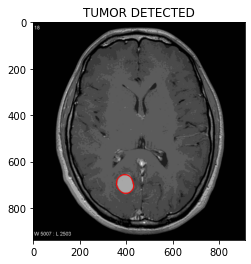

In [7]:
Tumoroutline("DATASETS/Y2.jpg")

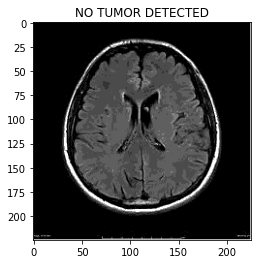

In [9]:
Tumoroutline("DATASETS/N2.jpg")